In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import IPython
from IPython.display import display
from PIL import Image
import os
import copy

from keras.preprocessing.image import img_to_array, array_to_img
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import keras.backend as K
from keras.layers import Lambda

In [2]:
!pip install pytorch-pretrained-bert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 1.9 MB/s eta 0:00:00


In [3]:
# Calculate FID
import sys
sys.path.insert(0, '/kaggle/input/cisc6000-deep-learning-hw3/helper/')
from utils import getFID
#getFID(real_images, generated_images) # Input should be two numpy arrays.

In [4]:
image = Image.open('/kaggle/input/cisc6000-deep-learning-hw3/celeba/train/000027.jpg') 
print(image.format)
print(image.size)
print(image.mode)

JPEG
(178, 218)
RGB


In [5]:
img = image.resize((128,128))
np_img = np.array(img)
print(np_img.shape)

(128, 128, 3)


In [6]:
#open training images
train=[]
j=0
for i in os.listdir('/kaggle/input/cisc6000-deep-learning-hw3/celeba/train'):
    if j >= 3000:
        break
        
    img = Image.open(os.path.join('/kaggle/input/cisc6000-deep-learning-hw3/celeba/train',i))
    img = img.resize((128,128))
    train.append(img_to_array(img))
    j += 1
    
x_train=np.array(train)
x_train.shape

(3000, 128, 128, 3)

In [7]:
#open test images
test=[]
j=0
for i in os.listdir('/kaggle/input/cisc6000-deep-learning-hw3/celeba/test'):
    if j >= 1000:
        break
    img = Image.open(os.path.join('/kaggle/input/cisc6000-deep-learning-hw3/celeba/test',i))
    img = img.resize((128,128))
    test.append(img_to_array(img))
    j+=1
    
x_test=np.array(test)
x_test.shape

(1000, 128, 128, 3)

In [8]:
#normalizes the supplied array and reshapes it into the appropriate format.
def preprocess(array):
    array = array.astype("float32") / 255.0
    #array = np.reshape(array, (len(array), 218, 178))
    return array

x_train = preprocess(x_train)
x_test = preprocess(x_test)

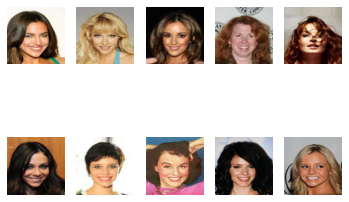

In [9]:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.subplots_adjust(hspace=0.5)
    plt.axis('off')

In [10]:
def sampler(layers):
  std_norm = K.random_normal(shape=(K.shape(layers[0])[0], 128), mean=0, stddev=1)
  return layers[0] + layers[1]*std_norm

In [11]:
#building autoencoder
latent_dim = 128
input = layers.Input(shape=(128,128,3))

#encoder
#input
x = layers.Conv2D(32,(2,2), activation='relu',padding='same',strides=(1,1))(input)
x = layers.MaxPooling2D((2,2),padding='same')(x)
#hidden layers
x = layers.Conv2D(32,(4,4),activation='relu',padding='same')(x)
x = layers.MaxPooling2D(2,2,padding='same')(x)
x = layers.Conv2D(16,(3,3),activation='relu',padding='same')(x)
x = layers.MaxPooling2D(2,2,padding='same')(x)
x = layers.Conv2D(8,(3,3),activation='relu',padding='same')(x)
shape = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
mean_layer = layers.Dense(latent_dim, activation='relu', kernel_initializer='he_normal', name="z_mean")(x)
sd_layer = layers.Dense(latent_dim, activation='relu', kernel_initializer='he_normal', name="z_log_var")(x)
#z = Sampling()([mean_layer, sd_layer])
latent_vector = Lambda(sampler)([mean_layer,sd_layer])

encoder = Model(input, latent_vector, name="encoder")
encoder.summary()

2022-12-13 21:01:25.726278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   16416       max_pooling2d[0][0]              
____________________________________________________________________________________________

2022-12-13 21:01:25.727245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 21:01:25.728256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 21:01:25.729042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 21:01:25.729781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 21:01:25.730508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [12]:
#decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = latent_inputs
x = layers.Dense(shape[1]*shape[2]*shape[3], activation="relu", kernel_initializer='he_normal')(x)
x = layers.Reshape((shape[1],shape[2],shape[3]))(x)
x = layers.Conv2DTranspose(40,(2,2),strides=2,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(32,(4,4),strides=2,activation='relu',padding='same')(x)
x = layers.Conv2DTranspose(16,(4,4),strides=2,activation='relu',padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(3,(5,5),activation='sigmoid',padding='same')(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              264192    
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 40)        1320      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        20512     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 16)      8208      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 128, 128, 3)       1203

In [13]:
vae = (tf.keras.Model(inputs=encoder.inputs,outputs=decoder(encoder.outputs)))
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   16416       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [14]:
vae.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_squared_error',
    metrics='accuracy'
)

In [15]:
vae.fit(
    x_train,
    x_train,
    batch_size=250,
    epochs=50,
    validation_split=0.25,
    shuffle = True
)

2022-12-13 21:01:35.183941: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-13 21:01:37.701114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


9/9 [==============================] - 16s 412ms/step - loss: 0.0905 - accuracy: 0.7406 - val_loss: 0.0903 - val_accuracy: 0.8178
Epoch 2/50
9/9 [==============================] - 3s 302ms/step - loss: 0.0885 - accuracy: 0.8263 - val_loss: 0.0875 - val_accuracy: 0.8178
Epoch 3/50
9/9 [==============================] - 3s 291ms/step - loss: 0.0857 - accuracy: 0.8263 - val_loss: 0.0849 - val_accuracy: 0.8178
Epoch 4/50
9/9 [==============================] - 3s 323ms/step - loss: 0.0835 - accuracy: 0.8263 - val_loss: 0.0816 - val_accuracy: 0.8178
Epoch 5/50
9/9 [==============================] - 3s 294ms/step - loss: 0.0781 - accuracy: 0.8263 - val_loss: 0.0740 - val_accuracy: 0.8177
Epoch 6/50
9/9 [==============================] - 3s 325ms/step - loss: 0.0695 - accuracy: 0.8263 - val_loss: 0.0659 - val_accuracy: 0.8178
Epoch 7/50
9/9 [==============================] - 3s 293ms/step - loss: 0.0632 - accuracy: 0.8263 - val_loss: 0.0614 - val_accuracy: 0.8177
Epoch 8/50
9/9 [==============

In [16]:
reconstructed_images = vae.predict(x_test)

In [17]:
latent_vector = encoder.predict(x_test)

In [18]:
latent_img=[]

for i in latent_vector:
    i = np.reshape(i,(16,8,1))
    img = array_to_img(i)
    latent_img.append(img)

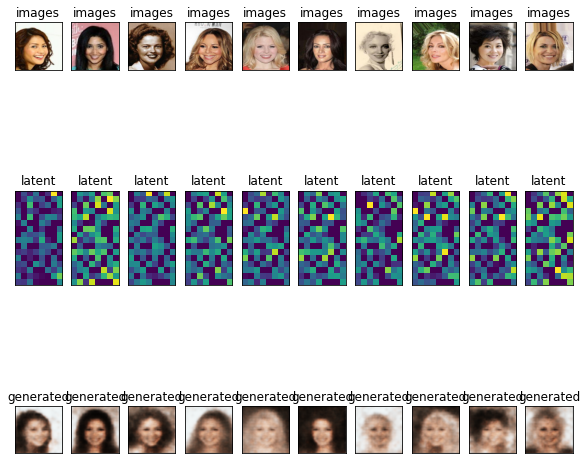

In [19]:
fig = plt.figure(figsize=(10,10))

for i in range(10):
    fig.add_subplot(3,10,i+1)
    plt.imshow(x_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('images')
    fig.add_subplot(3,10,10+(i+1))
    plt.imshow(latent_img[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('latent')
    fig.add_subplot(3,10,20+(i+1))
    plt.imshow(reconstructed_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('generated')

In [20]:
#L2 FID reconstructed scores
#getFID(x_test, reconstructed_images)

#FID of your Fake Output: 49.653

In [21]:
#randomly select from latent vector
#import random
#from random import sample

#z_sample = tf.random.normal(shape=[1000, latent_vector],mean=0,stddev=1)
#random1 = decoder.predict(z_sample)

#get L2 genereated FID score
#getFID(x_test, l2_generated)

In [22]:
vae.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics='accuracy'
)

In [23]:
vae.fit(
    x_train,
    x_train,
    batch_size=250,
    epochs=50,
    validation_split=0.25,
    shuffle = True
)

Epoch 1/50
9/9 [==============================] - 5s 427ms/step - loss: 0.1795 - accuracy: 0.7504 - val_loss: 0.1411 - val_accuracy: 0.8016
Epoch 2/50
9/9 [==============================] - 3s 312ms/step - loss: 0.1254 - accuracy: 0.8000 - val_loss: 0.1201 - val_accuracy: 0.7387
Epoch 3/50
9/9 [==============================] - 3s 330ms/step - loss: 0.1133 - accuracy: 0.7905 - val_loss: 0.1084 - val_accuracy: 0.8113
Epoch 4/50
9/9 [==============================] - 3s 313ms/step - loss: 0.1050 - accuracy: 0.8175 - val_loss: 0.1023 - val_accuracy: 0.7935
Epoch 5/50
9/9 [==============================] - 3s 304ms/step - loss: 0.1001 - accuracy: 0.8053 - val_loss: 0.0993 - val_accuracy: 0.7995
Epoch 6/50
9/9 [==============================] - 3s 309ms/step - loss: 0.0973 - accuracy: 0.8123 - val_loss: 0.0971 - val_accuracy: 0.7985
Epoch 7/50
9/9 [==============================] - 3s 338ms/step - loss: 0.0978 - accuracy: 0.8117 - val_loss: 0.1035 - val_accuracy: 0.7954
Epoch 8/50
9/9 [====

In [24]:
reconstructed_images = vae.predict(x_test)

In [25]:
latent_vector = encoder.predict(x_test)

In [26]:
latent_img=[]

for i in latent_vector:
    i = np.reshape(i,(16,8,1))
    img = array_to_img(i)
    latent_img.append(img)

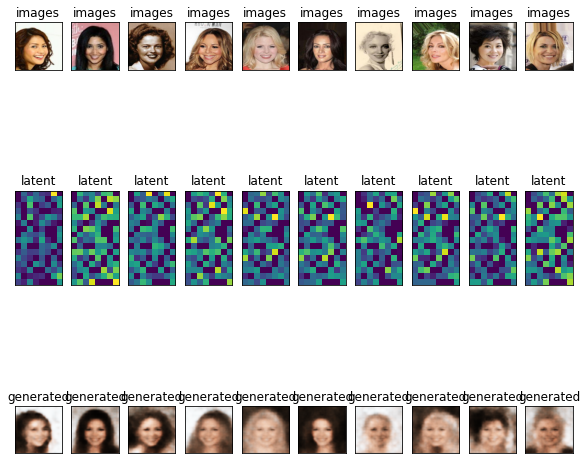

In [27]:
fig = plt.figure(figsize=(10,10))

for i in range(10):
    fig.add_subplot(3,10,i+1)
    plt.imshow(x_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('images')
    fig.add_subplot(3,10,10+(i+1))
    plt.imshow(latent_img[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('latent')
    fig.add_subplot(3,10,20+(i+1))
    plt.imshow(reconstructed_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('generated')

In [28]:
#L1 FID reconstructed scores
#getFID(x_test, reconstructed_images)

#FID of your Fake Output: 44.925

In [29]:
#randomly select from latent vector

#z_sample = tf.random.normal(shape=[1000, latent_vector],mean=0,stddev=1)
#random1 = decoder.predict(z_sample)
